<a href="https://colab.research.google.com/github/amank56/Stock-prediction/blob/master/Stock_pridict_bidirectional_attention_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import re

In [6]:
from google.colab import files
uploaded = files.upload()

Saving Ds_apple.csv to Ds_apple.csv
Saving Ds_Apple_04-26-2020.csv to Ds_Apple_04-26-2020.csv
Saving Ds_Apple_04-28-2020.csv to Ds_Apple_04-28-2020.csv
Saving Ds_Apple_04-29-2020.csv to Ds_Apple_04-29-2020.csv
Saving Ds_Apple_04-30-2020.csv to Ds_Apple_04-30-2020.csv


In [0]:
import io
ds0 = pd.read_csv(io.BytesIO(uploaded['Ds_apple.csv']))
ds1 = pd.read_csv(io.BytesIO(uploaded['Ds_Apple_04-26-2020.csv']))
ds2 = pd.read_csv(io.BytesIO(uploaded['Ds_Apple_04-28-2020.csv']))
ds3 = pd.read_csv(io.BytesIO(uploaded['Ds_Apple_04-29-2020.csv']))
ds4 = pd.read_csv(io.BytesIO(uploaded['Ds_Apple_04-30-2020.csv']))

frames=[ds0,ds1,ds2,ds3,ds4]
df=pd.concat(frames)
#df= pd.read_csv("/content/Ds_Apple.csv")

In [12]:
df.head()

,Unnamed: 0,Firm,Date,Headlines,Label,Description,Open,Close
0,0,Apple,11/20/2006,Mac fans buzzing about expected Apple iPhone,1,SAN FRANCISCO Reuters The longrumored arriv...,12.200000,12.352858
1,1,Apple,12/13/2006,Apple iTunes music sales collapses in H1 survey,1,AMSTERDAM Reuters Sales at Apples online mu...,12.564285,12.721429
2,2,Apple,12/13/2006,Piper Jaffray disputes report of weak iTunes s...,1,NEW YORK Reuters Digital music sales surged...,12.564285,12.721429
3,3,Apple,12/15/2006,Apple files to delay annual report for option ...,0,WASHINGTON Reuters Apple Computer Inc AAPL...,12.717143,12.531428
4,4,Apple,12/27/2006,Apple shares recover,1,BOSTON Reuters Apple Computer Inc shares fe...,11.164286,11.645715


In [0]:
#processing the text of headline/Description

col_name='Headlines'
# Remove all the special characters
df[col_name]=df[col_name].map(lambda x: re.sub(r'\W+', ' ', x))

# remove all single characters
df[col_name]=df[col_name].map(lambda x: re.sub(r'\s+[a-zA-Z]\s+',' ',x))

# Remove single characters from the start
df[col_name]=df[col_name].map(lambda x: re.sub(r'\^[a-zA-Z]\s+',' ',x))

#Substituting multiple spaces with single space
df[col_name]=df[col_name].map(lambda x: re.sub(r'\s+', ' ',x,flags=re.I))

# Removing prefixed 'b'
df[col_name]=df[col_name].map(lambda x: re.sub(r'^b\s+', ' ',x))

Understand the distribution better.


Text(0.5, 1.0, 'Number of +ive and -ive messages - 0 is -ve and +ive is 1')

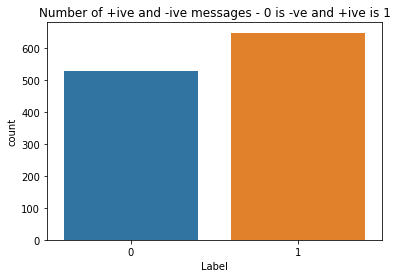

In [13]:
sns.countplot(df.Label)
plt.xlabel('Label')
plt.title('Number of +ive and -ive messages - 0 is -ve and +ive is 1')

1. Create input and output vectors.

2. Process the labels.

In [0]:
X = df.Headlines
Y = df.Label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Split into training and test data.

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

**Process the data**

Tokenize the data and convert the text to sequences.

Add padding to ensure that all the sequences have the same shape.

There are many ways of taking the max_len and here an arbitrary length of 150 is chosen

In [0]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

**RNN**

Define the RNN structure.

In [0]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Call the function and compile the model.

In [18]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

Fit on the training data.

In [19]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 2s 3ms/step - loss: 0.6913 - accuracy: 0.5475 - val_loss: 0.6818 - val_accuracy: 0.5950
Epoch 2/10
800/800 [==============================] - 2s 2ms/step - loss: 0.6851 - accuracy: 0.5462 - val_loss: 0.6864 - val_accuracy: 0.6050


Process the test set data.

In [0]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

Evaluate the model on the test set.

In [21]:
accr = model.evaluate(test_sequences_matrix,Y_test)

177/177 [==============================] - 0s 719us/step


In [22]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.689
  Accuracy: 0.508


**Bidirectional LSTM**

In [0]:
def BiDirRNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = Bidirectional(LSTM(64))(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Model Summary


In [30]:
bimodel = BiDirRNN()
bimodel.summary()
bimodel.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               58880     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               33024     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [31]:
bimodel.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 4s 4ms/step - loss: 0.6914 - accuracy: 0.5213 - val_loss: 0.6798 - val_accuracy: 0.5950
Epoch 2/10
800/800 [==============================] - 3s 3ms/step - loss: 0.6860 - accuracy: 0.5487 - val_loss: 0.6739 - val_accuracy: 0.5950
Epoch 3/10
800/800 [==============================] - 3s 3ms/step - loss: 0.6711 - accuracy: 0.5587 - val_loss: 0.6805 - val_accuracy: 0.5250


Evaluate the model on the test set.

In [33]:
accr_bi = bimodel.evaluate(test_sequences_matrix,Y_test)

177/177 [==============================] - 0s 1ms/step


In [35]:
print('Bidirectional LSTM - Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_bi[0],accr_bi[1]))

Bidirectional LSTM - Test set
  Loss: 0.675
  Accuracy: 0.638


**Bidirectional LSTM and Attention**


In [0]:
# Attention Class taken from https://www.kaggle.com/takuok/bidirectional-lstm-and-attention-lb-0-043

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):        
        #assert len(input_shape) == 3
        
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [0]:
def BiDir_Attn_RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = Bidirectional(LSTM(64))(layer)
    layer = Attention(max_len)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [0]:
#bi_attn_model = BiDir_Attn_RNN()
#bi_attn_model.summary()
#bi_attn_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

TypeError: ignored

In [0]:
bi_attn_model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])